In [2]:
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
#import mpl_toolkits.basemap.pyproj as pyproj
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
# import cartopy.crs as ccrs

In [2]:
# # ensure we have Helvetica available
# fm.findSystemFonts(fontpaths='/users/sth/fonts', fontext='ttf')
# prop = fm.FontProperties(fname='/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-R.ttf')

# # Convenience functions for working with color ramps and bars
# import matplotlib
# def colorbar_index(ncolors, cmap, labels=None, **kwargs):
#     """
#     This is a convenience function to stop you making off-by-one errors
#     Takes a standard colourmap, and discretizes it,
#     then draws a colour bar with correctly aligned labels
#     """
#     cmap = cmap_discretize(cmap, ncolors)
#     mappable = cm.ScalarMappable(cmap=cmap)
#     mappable.set_array([])
#     mappable.set_clim(-0.5, ncolors+0.5)
#     colorbar = plt.colorbar(mappable, **kwargs)
#     colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
#     colorbar.set_ticklabels(range(ncolors))
#     if labels:
#         colorbar.set_ticklabels(labels)
#     return colorbar

# def cmap_discretize(cmap, N):
#     """
#     Return a discrete colormap from the continuous colormap cmap.
    
#         cmap: colormap instance, eg. cm.jet. 
#         N: number of colors.
    
#     Example
#         x = resize(arange(100), (5,100))
#         djet = cmap_discretize(cm.jet, 5)
#         imshow(x, cmap=djet)

#     """
#     if type(cmap) == str:
#         cmap = get_cmap(cmap)
#     colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
#     colors_rgba = cmap(colors_i)
#     indices = np.linspace(0, 1., N + 1)
#     cdict = {}
#     for ki,key in enumerate(('red','green','blue')):
#         cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
#     return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [3]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('data/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

IOError: no such file or directory: 'data/london_wards.shp'

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f74570de4e0>)

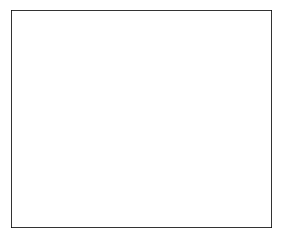

In [5]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'data/london_wards',
    'london',
    color='none',
    zorder=2)

In [6]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['NAME'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['NAME'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [7]:
data_file1 = 'data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = 'greater_london_points.csv'

gsview_lonlat = {}
fdata = {}
fdata_map_points = {}
gsview_data = {}
all_tags = {}
count = 0
threshold = 0.95

with open(lonlat_data_file, 'r', encoding='utf-8') as infile:
    for line in infile:
        fields = line.strip().split(',')
        gsview_lonlat['_'.join([fields[0], fields[1], '0'])] = (float(fields[2]),float(fields[3]))               
        
count = 0
with open(data_file1, 'r', encoding='utf-8') as infile:
    for line in infile:
        count += 1
        
        if count == 1:
            continue
        fields = line.strip().split('|')
        # ignore the rotation tag 0,1,2,4 for angle of rotation
        if len(fields) < 2:
            continue
        
        way_id   = fields[0]
        point_id = fields[1]
        rotation = fields[2]
        fields[3] = fields[3][1:-1]
        scene_list = list(map(float, fields[3].split(', ')))
        latitude  = gsview_lonlat['_'.join(fields[:3])][0]
        longitude = gsview_lonlat['_'.join(fields[:3])][1]
        fdata_map_points[m(longitude, latitude)] = scene_list
        

In [8]:
map_points = pd.Series(
    [Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

In [9]:
len(df_map)

627

In [10]:
df_map['borough_name']

0               Chessington South Ward
1          Tolworth and Hook Rise Ward
2                      Berrylands Ward
3                       Alexandra Ward
4                        Beverley Ward
5                     Coombe Hill Ward
6      Chessington North and Hook Ward
7                   Surbiton Hill Ward
8                      Old Malden Ward
9                      St. Mark's Ward
10                          Grove Ward
11                        Canbury Ward
12                       Norbiton Ward
13                    Coombe Vale Ward
14                      St. James Ward
15                          Tudor Ward
16                  Coulsdon East Ward
17           Selsdon and Ballards Ward
18                  Coulsdon West Ward
19                         Waddon Ward
20                         Kenley Ward
21                         Purley Ward
22                    Sanderstead Ward
23                     Heathfield Ward
24                      Fairfield Ward
25                    Bro

In [11]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [12]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags

cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

scene_tags_transpose = list(zip(*scene_tags))

for index in range(len(cats)):
    cat = cats[index]
    df_map[cat] = scene_tags_transpose[index]

In [13]:
df_map['gsview_tags'].iloc[0]

array([0.30453187, 0.1371739 , 0.00778149, 0.00828417, 0.18212216,
       0.07428112, 0.21588047, 0.00092778, 0.02401823, 0.04197787,
       0.00204985, 0.0009711 ])

In [14]:
df_map.columns

Index(['borough_name', 'poly', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'Sky', 'Building', 'Pole',
       'Road_Marking', 'Road', 'Pavement', 'Tree', 'Sign_Symbol', 'Fence',
       'Vehicle', 'Pedestrian', 'Bike'],
      dtype='object')

In [15]:
#df_map['gsview_tags'].plot.hist()
#sns.barplot(data=[np.array(df_map['gsview_tags'].iloc[19]),range(205)])
#sns.distplot(df_map['gsview_tags'].iloc[19]);
import numpy as np
cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

top5 = [19, 27, 25, 29, 21]

for i in top5:
    places_list = np.array(df_map['gsview_tags'].iloc[i])
    ind = np.argpartition(places_list, -5)[-5:]
    ind = ind[np.argsort(places_list[ind])][::-1]
    for j in ind:
        place = cats[j]
        print (place, " : ", places_list[j])
    print ('==========')    
    
#print (places)
#width = 1/1.5
#plt.bar(range(205), df_map['gsview_tags'].iloc[19], width, color="blue")



Sky  :  0.2430687618708451
Tree  :  0.23805878294159546
Road  :  0.1814707235280153
Building  :  0.15325914055080728
Pavement  :  0.08602719907407409
Sky  :  0.27662675865800856
Building  :  0.2628146043771043
Road  :  0.1618668079605579
Pavement  :  0.09922092953342955
Tree  :  0.07911112614237617
Sky  :  0.27221936728395063
Building  :  0.22048657407407413
Road  :  0.1916836419753088
Tree  :  0.1255858796296297
Pavement  :  0.08064645061728391
Sky  :  0.29637006438910174
Tree  :  0.25805768412090246
Road  :  0.1756881917837377
Building  :  0.10213747871434654
Pavement  :  0.07021292305236271
Sky  :  0.29076215277777784
Tree  :  0.25559459876543217
Road  :  0.18059672067901225
Building  :  0.11867685185185183
Pavement  :  0.06626165123456791


In [16]:
top5 = [31, 5, 32, 30, 26]

cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

for i in top5:
    places_list = np.array(df_map['gsview_tags'].iloc[i])
    ind = np.argpartition(places_list, -5)[-5:]
    ind = ind[np.argsort(places_list[ind])][::-1]
    for j in ind:
        place = cats[j]
        print (place, " : ", places_list[j])
    print ('==========')    

Sky  :  0.3254156057098765
Tree  :  0.17334355709876537
Road  :  0.1633095100308642
Building  :  0.15382513503086417
Pavement  :  0.08363474151234568
Sky  :  0.4812529906164557
Tree  :  0.19817156817051979
Road  :  0.13952037503107131
Building  :  0.06197990461098684
Pavement  :  0.052448305058414156
Sky  :  0.2820528442215362
Tree  :  0.24419667352537727
Road  :  0.15818372770919067
Building  :  0.13397215792181075
Pavement  :  0.084516300154321
Tree  :  0.24532232042648716
Sky  :  0.2372335332491583
Road  :  0.17861097958754205
Building  :  0.16619620686026945
Pavement  :  0.08401300329685744
Sky  :  0.2666602860873694
Building  :  0.2369094254510921
Road  :  0.18479070216049384
Tree  :  0.10751810303893639
Pavement  :  0.07997981956315292


In [50]:
df_map.columns

Index(['borough_name', 'poly', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'Sky', 'Building', 'Pole',
       'Road_Marking', 'Road', 'Pavement', 'Tree', 'Sign_Symbol', 'Fence',
       'Vehicle', 'Pedestrian', 'Bike'],
      dtype='object')

In [17]:
df_map.to_pickle('wards_segnet.pkl')